In [8]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
generator = tf.keras.models.load_model('AMPLify-Feedback/model_weights/PeptideGenerator_new.keras')

In [3]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [4]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [5]:
aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')

In [40]:
def onehot2seq(onehot):
    demo_seq = tf.math.argmax(onehot, axis=2)
    demo_seq = pep_decoder(demo_seq).numpy().astype('str')
    demo_seq = ["".join(chars) for chars in demo_seq]
    return demo_seq

In [46]:
num_sequences = 20000
bacteria = np.zeros(shape=(num_sequences, 326))
bacteria[:, 1] = 1 #'Bacillus_subtilis'
np.random.seed(8701)
noise = (np.random.rand(num_sequences, 2)-0.5)*2
generated_onehot = generator.predict(noise, verbose=0)
MIC = oracle.predict([generated_onehot, bacteria], verbose=0)
generated_sequences = onehot2seq(generated_onehot)
vis_data = np.concatenate([noise, np.array(generated_sequences).reshape(num_sequences, 1), MIC], axis=1)
vis_data = pd.DataFrame(vis_data, columns=["Noise_1", "Noise_2", "Peptide", "MIC"])

In [54]:
vis_data['MIC'] = vis_data['MIC'].astype('float64')

In [58]:
vis_data.nsmallest(20, 'MIC')

,Noise_1,Noise_2,Peptide,MIC
821,-0.07061561679223982,0.40309968344413183,DLLLIFILR,1.819413
1260,-0.0597221915742856,0.3981776240063739,DLLLIFILR,1.820891
15760,-0.0596654899589002,0.39084924314222214,DLLLIFILR,1.825562
16018,-0.061012579905992625,0.4110290033272106,DLLLIFILR,1.830283
19135,-0.058270420224241004,0.41598978881296955,DLLLIFILR,1.835808
17209,-0.07432341135248066,0.418425762323682,DLLLLFILR,1.842800
1373,-0.17327056384037154,-0.3807211637995891,RPIRRR,1.863604
1913,-0.1778057483240565,-0.3693900291232832,RPIRRR,1.865101
5253,-0.1733804045867544,-0.3694867033795852,RPIRRR,1.865530
12040,-0.1797177241568071,-0.36971328626022926,RPIRRR,1.865779


In [41]:
onehot2seq(generated_sequences[0:10])

['VPQYVGLFF',
 'RAKKAAPLAIKM',
 'VPVYVGDFF',
 'RAKKAAPLAAVMQ',
 'ALLKAAPLAKRL',
 'DMLKLLLKAGKRL',
 'MLKIAILVATR',
 'VPVYVGD',
 'VPYMGF',
 'VPSYTDE']

<Axes: xlabel='Noise_1', ylabel='Noise_2'>

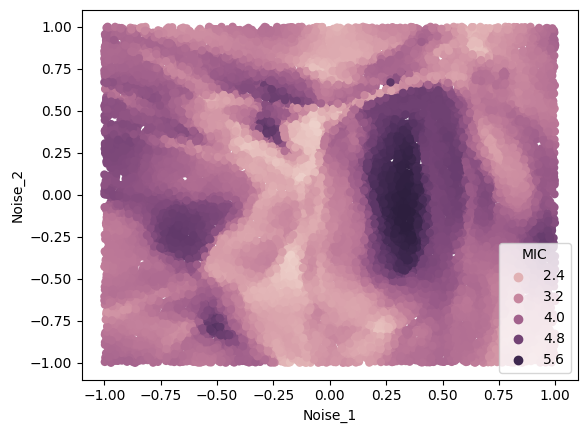

In [38]:
sns.scatterplot(vis_data, x="Noise_1", y="Noise_2", hue="MIC", linewidth=0)